# 4. Prediction network

In [1]:
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from autoencoder_dropout import *
from prediction import *
from data import *

from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')

from tqdm import tqdm

df = pipeline()
time_steps = 48
y_time_steps = 12
datasets = samples(df, time_steps, y_time_steps)

In [2]:
autoencoder = torch.load('saved_models/autoencoder_dropout.pt')
encoder     = autoencoder.encoder.eval()
predictor   = Prediction(145)

In [3]:
batch_size = 128
learning_rate = 0.001

train_dataloader = DataLoader(TrafficDataset(datasets,set_='train'),
                              batch_size=batch_size,
                              shuffle=True)
optimiser = optim.Adam(lr=learning_rate,
                       params=predictor.parameters())

losses = []

In [4]:
num_epochs = 100
pbar = tqdm(range(num_epochs))

for epoch in pbar:
    for i, (x,y) in enumerate(train_dataloader):
        embedding = encoder(x).view(-1, 48)
        exogenous_x = x[:,-1,:]

        x2 = torch.cat([embedding, exogenous_x], dim=1)
        y_pred = predictor(x2)

        optimiser.zero_grad()
        loss = F.mse_loss(y, y_pred)
        loss.backward()
        optimiser.step()
        
        step = (epoch * len(train_dataloader.dataset) +
                i * batch_size + len(x))
        losses.append([step, loss.item()])
        pbar.set_description("Epoch={0} | [{1:>5}|{2}]\t loss={3:.4f}"
                             .format(epoch,
                                     i * batch_size + len(x),
                                     len(train_dataloader.dataset),
                                     loss.item()))

Epoch=99 | [11501|11501]	 loss=0.0469: 100%|██████████| 100/100 [27:03<00:00, 16.23s/it]


## Plot training loss after 100 epochs

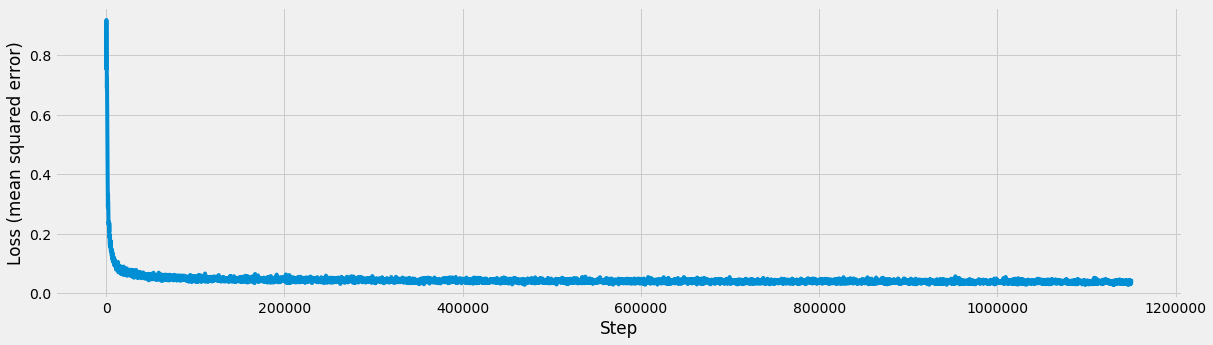

In [5]:
fig = plt.figure(figsize=(18,5))
ax  = fig.add_subplot(1,1,1)
_   = ax.plot(*np.array(losses)[:].T,label='training loss')
_   = ax.set_ylabel('Loss (mean squared error)')
_   = ax.set_xlabel('Step')

## Plot predictions after 100 epochs

Turn on dropout layers for MC dropout

In [6]:
def dropout_on(m):
    if type(m) == torch.nn.Dropout:
        m.train()

predictor_inf = predictor.eval().apply(dropout_on)

In [8]:
test_data = TrafficDataset(datasets, set_='test')
test_dataloader = DataLoader(test_data,
                             batch_size=len(test_data),
                             shuffle=True)
for x,y in test_dataloader:
    break

y_preds = []
for b in range(128):
    embedding = encoder(x).view(-1, 48)
    exogenous_x = x[:,-1,:]

    x2 = torch.cat([embedding, exogenous_x], dim=1)
    y_pred = predictor_inf(x2).detach().numpy()
    y_preds.append(y_pred)

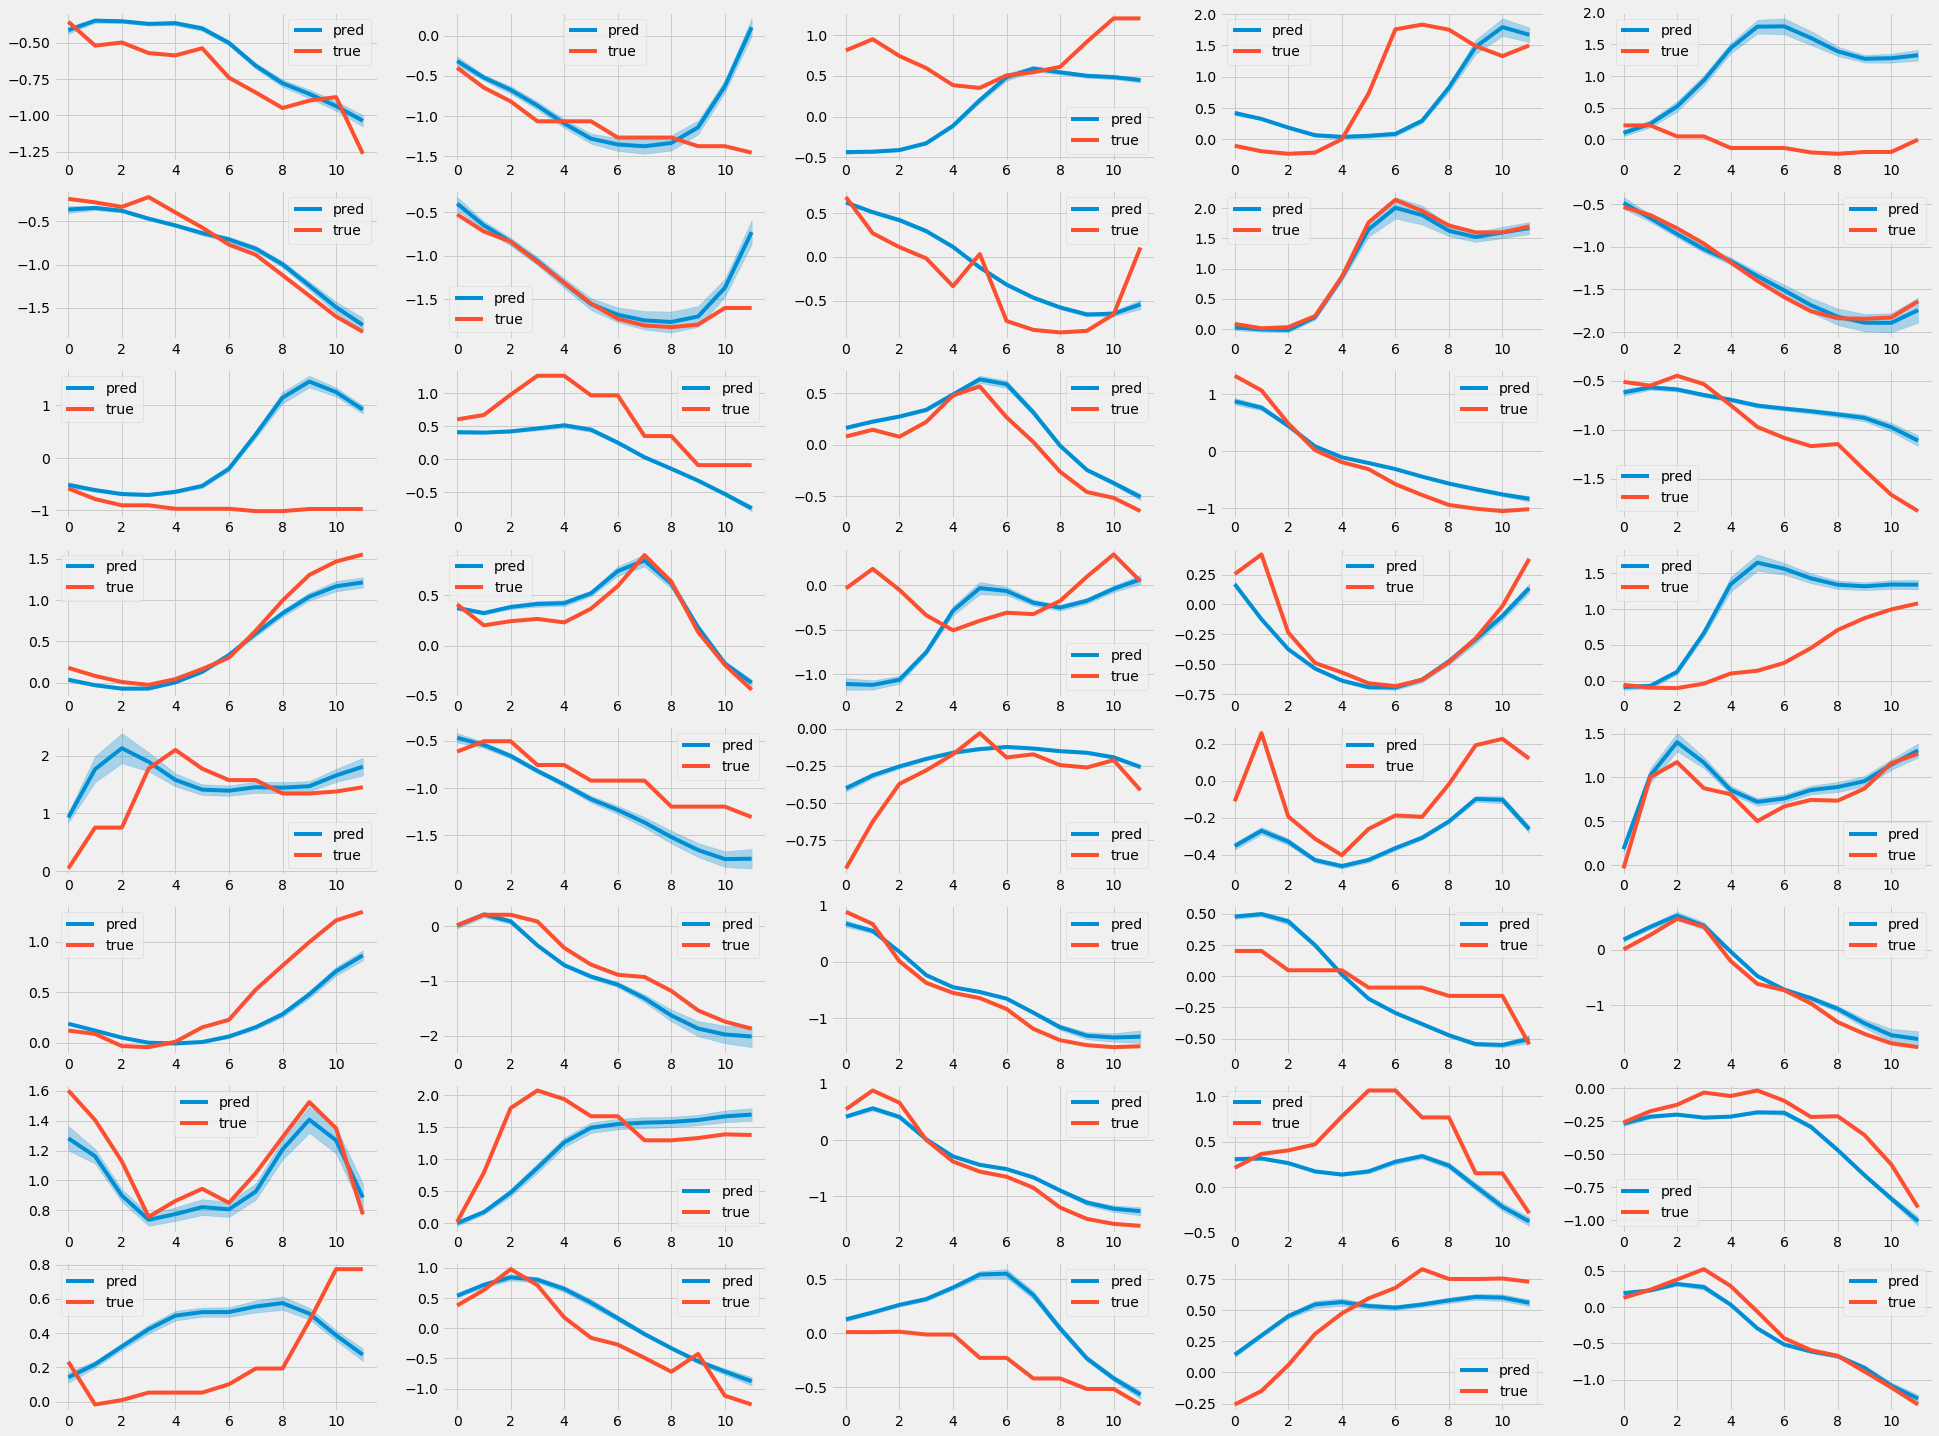

In [9]:
y_mu  = np.mean(y_preds,axis=0)
y_var = np.var(y_preds,axis=0)

fig = plt.figure(figsize=(6*5,3*8))
for i in range(40):
    ax = fig.add_subplot(8,5,i+1)
    ax.plot(y_mu[i],label='pred')
    ax.fill_between(np.arange(12),
                    y_mu[i]+2*y_var[i],
                    y_mu[i]-2*y_var[i],
                    color='C0',alpha=0.3)
    ax.plot(y[i,:].numpy(),label='true')
    ax.legend()

In [24]:
torch.save(predictor,'saved_models/predictor.pt')